In [27]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms

0.90 - For proving that using pre-trained model works better

In [28]:
train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm", 0.90)

Found 688 files belonging to 2 classes.
Using 69 files for training.
Using 619 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (32, 4000)
Example label shape: (32,)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [29]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

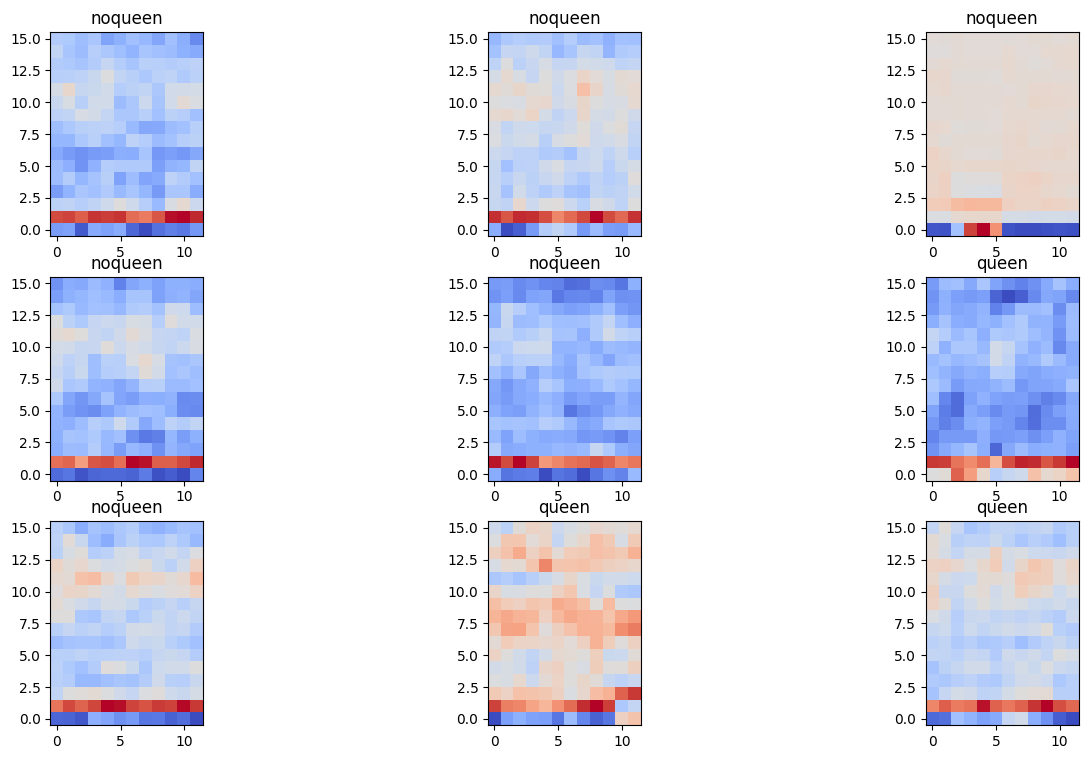

In [30]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [31]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 16, 1])

In [32]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

Epoch 1/20
1/3 [=========>....................] - ETA: 0s - loss: 0.7000 - accuracy: 0.5938

2024-03-23 14:54:48.146160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


3/3 [==============================] - 1s 267ms/step - loss: 1.0125 - accuracy: 0.4783 - val_loss: 0.6000 - val_accuracy: 0.8078
Epoch 2/20
3/3 [==============================] - 0s 78ms/step - loss: 0.7867 - accuracy: 0.6087 - val_loss: 0.7571 - val_accuracy: 0.4992
Epoch 3/20
3/3 [==============================] - 0s 78ms/step - loss: 0.6334 - accuracy: 0.6377 - val_loss: 0.6225 - val_accuracy: 0.5137
Epoch 4/20
3/3 [==============================] - 0s 78ms/step - loss: 0.5297 - accuracy: 0.7681 - val_loss: 0.5983 - val_accuracy: 0.7803
Epoch 5/20
3/3 [==============================] - 0s 89ms/step - loss: 0.4984 - accuracy: 0.7391 - val_loss: 0.5760 - val_accuracy: 0.7819
Epoch 6/20
3/3 [==============================] - 0s 80ms/step - loss: 0.4526 - accuracy: 0.8261 - val_loss: 0.5576 - val_accuracy: 0.7173
Epoch 7/20
3/3 [==============================] - 0s 84ms/step - loss: 0.4076 - accuracy: 0.8551 - val_loss: 0.5369 - val_accuracy: 0.7367
Epoch 8/20
3/3 [=====================

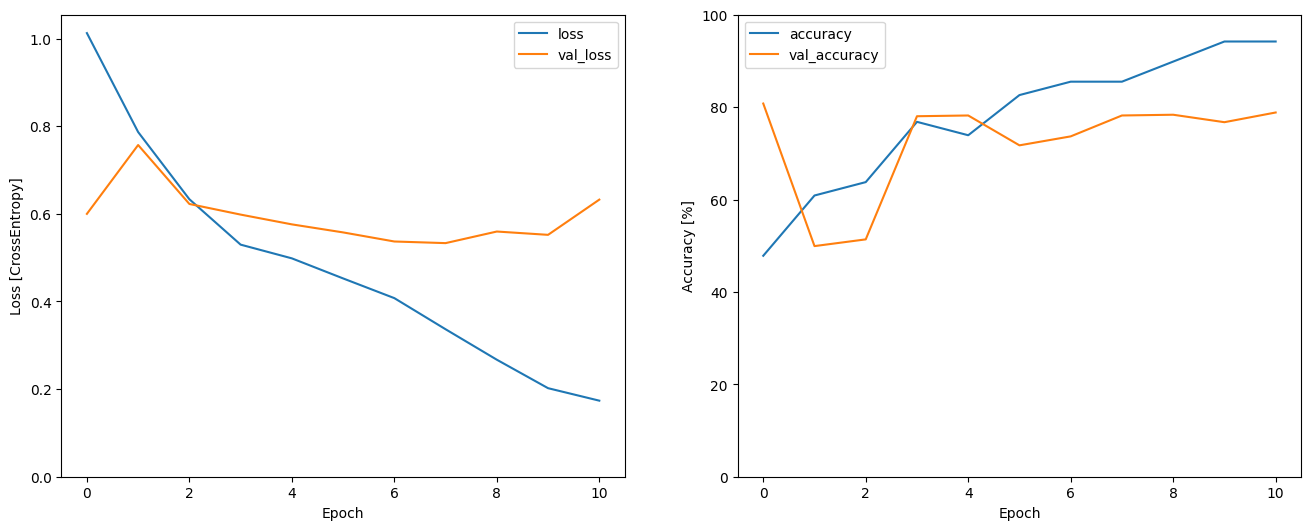

In [33]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/20
3/3 [==============================] - 1s 133ms/step - loss: 0.6955 - accuracy: 0.5072 - val_loss: 0.6897 - val_accuracy: 0.5137
Epoch 2/20
3/3 [==============================] - 0s 36ms/step - loss: 0.6441 - accuracy: 0.5652 - val_loss: 0.7372 - val_accuracy: 0.4992
Epoch 3/20
3/3 [==============================] - 0s 34ms/step - loss: 0.6785 - accuracy: 0.5507 - val_loss: 0.7425 - val_accuracy: 0.4992
Epoch 4/20
3/3 [==============================] - 0s 34ms/step - loss: 0.6521 - accuracy: 0.5507 - val_loss: 0.6774 - val_accuracy: 0.5105
Epoch 5/20
3/3 [==============================] - 0s 37ms/step - loss: 0.5919 - accuracy: 0.6087 - val_loss: 0.6400 - val_accuracy: 0.5590
Epoch 6/20
3/3 [==============================] - 0s 42ms/step - loss: 0.5632 - accuracy: 0.7246 - val_loss: 0.6138 - val_accuracy: 0.6268
Epoch 7/20
3/3 [==============================] - 0s 36ms/step - loss: 0.5459 - accuracy: 0.8116 - val_loss: 0.6001 - val_accuracy: 0.6607
Epoch 8/20
3/3 [==========

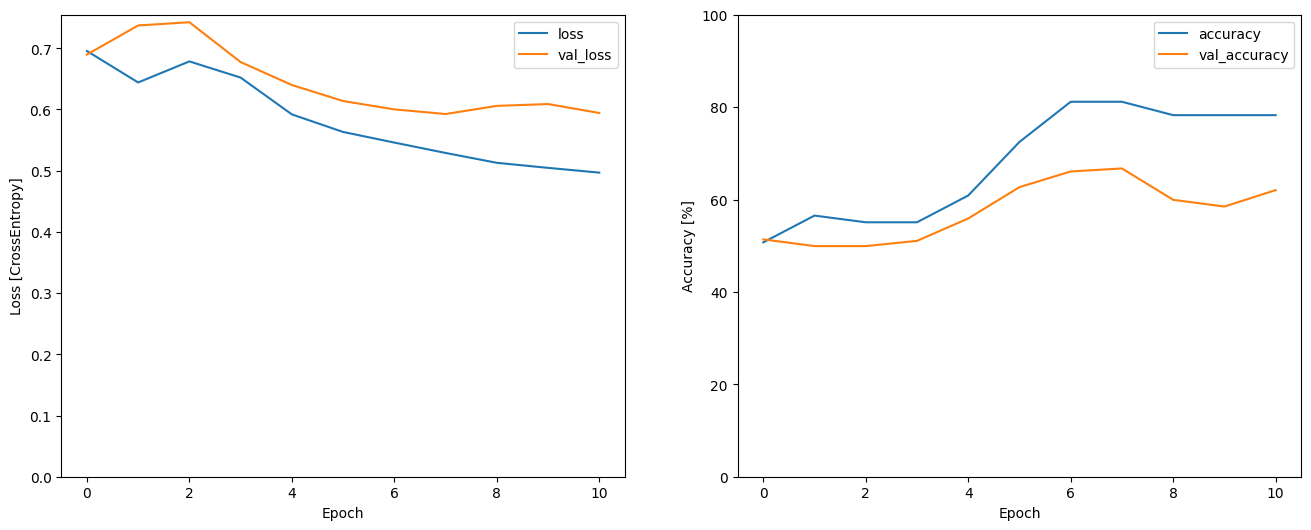

In [34]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


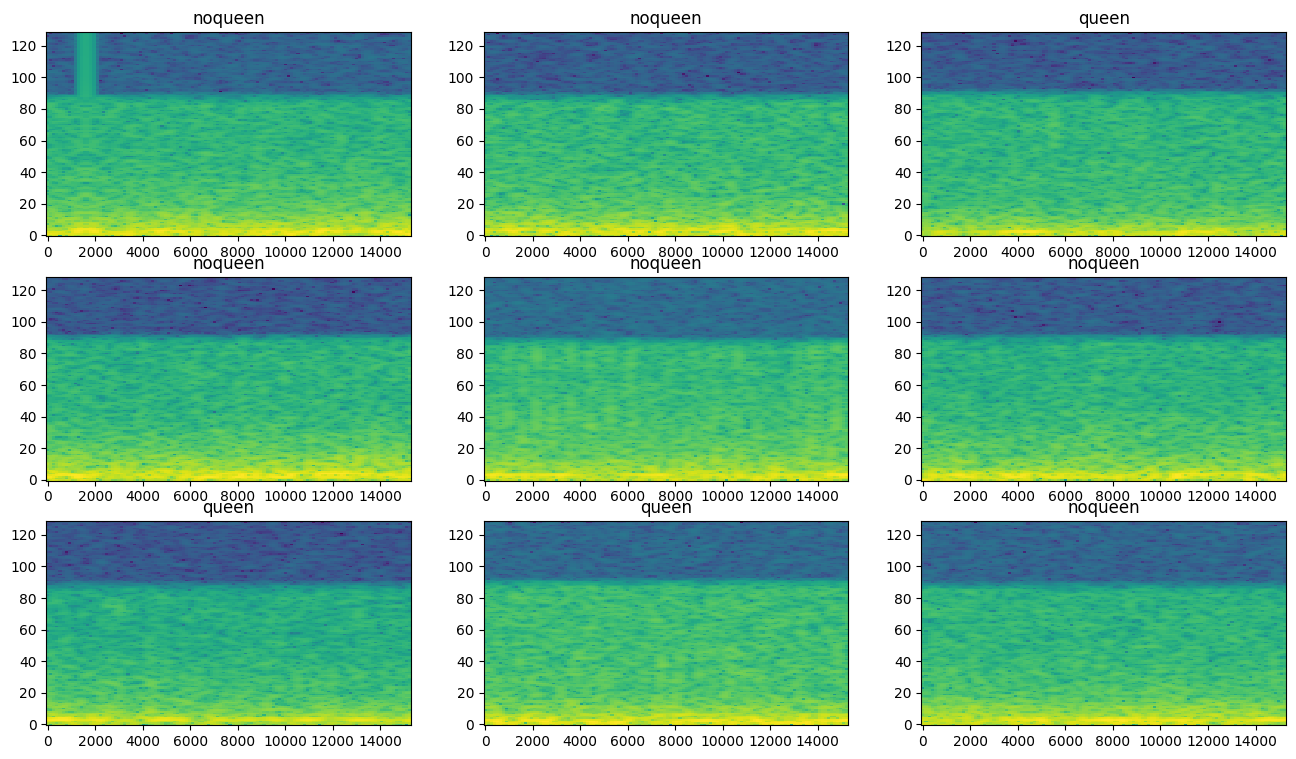

In [35]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [36]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/60
3/3 [==============================] - 1s 224ms/step - loss: 0.8853 - accuracy: 0.4928 - val_loss: 0.7884 - val_accuracy: 0.4992
Epoch 2/60
3/3 [==============================] - 0s 77ms/step - loss: 0.7558 - accuracy: 0.5217 - val_loss: 0.6902 - val_accuracy: 0.5509
Epoch 3/60
3/3 [==============================] - 0s 87ms/step - loss: 0.6735 - accuracy: 0.6232 - val_loss: 0.6917 - val_accuracy: 0.5040
Epoch 4/60
3/3 [==============================] - 0s 75ms/step - loss: 0.6572 - accuracy: 0.6522 - val_loss: 0.6870 - val_accuracy: 0.5073
Epoch 5/60
3/3 [==============================] - 0s 75ms/step - loss: 0.6327 - accuracy: 0.7101 - val_loss: 0.6844 - val_accuracy: 0.5493
Epoch 6/60
3/3 [==============================] - 0s 76ms/step - loss: 0.5917 - accuracy: 0.7536 - val_loss: 0.6922 - val_accuracy: 0.5089
Epoch 7/60
3/3 [==============================] - 0s 76ms/step - loss: 0.5621 - accuracy: 0.7101 - val_loss: 0.7033 - val_accuracy: 0.5024
Epoch 8/60
3/3 [==========

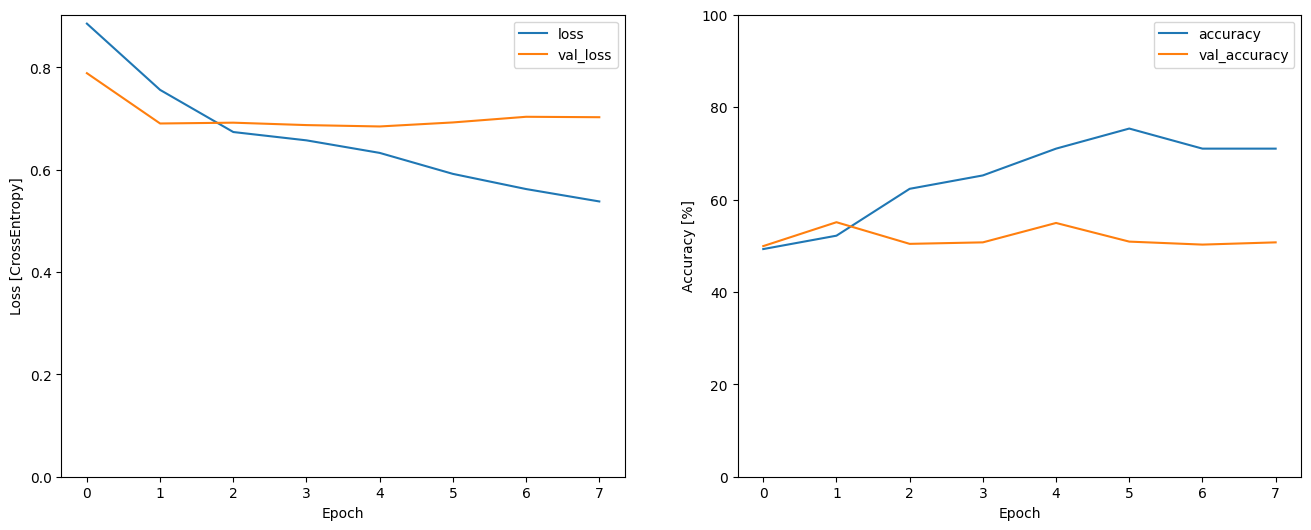

In [37]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=60,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/50
3/3 [==============================] - 1s 164ms/step - loss: 1.9305 - accuracy: 0.4348 - val_loss: 0.7214 - val_accuracy: 0.5153
Epoch 2/50
3/3 [==============================] - 0s 82ms/step - loss: 0.9851 - accuracy: 0.4493 - val_loss: 1.1342 - val_accuracy: 0.4992
Epoch 3/50
3/3 [==============================] - 0s 84ms/step - loss: 1.0108 - accuracy: 0.5507 - val_loss: 0.8475 - val_accuracy: 0.4992
Epoch 4/50
3/3 [==============================] - 0s 60ms/step - loss: 0.7714 - accuracy: 0.5507 - val_loss: 0.7318 - val_accuracy: 0.4992
Epoch 5/50
3/3 [==============================] - 0s 66ms/step - loss: 0.6980 - accuracy: 0.5507 - val_loss: 0.7203 - val_accuracy: 0.4992
Epoch 6/50
3/3 [==============================] - 0s 82ms/step - loss: 0.6928 - accuracy: 0.5507 - val_loss: 0.7237 - val_accuracy: 0.5008
Epoch 7/50
3/3 [==============================] - 0s 66ms/step - loss: 0.6896 - accuracy: 0.5652 - val_loss: 0.7485 - val_accuracy: 0.5008
Epoch 8/50
3/3 [==========

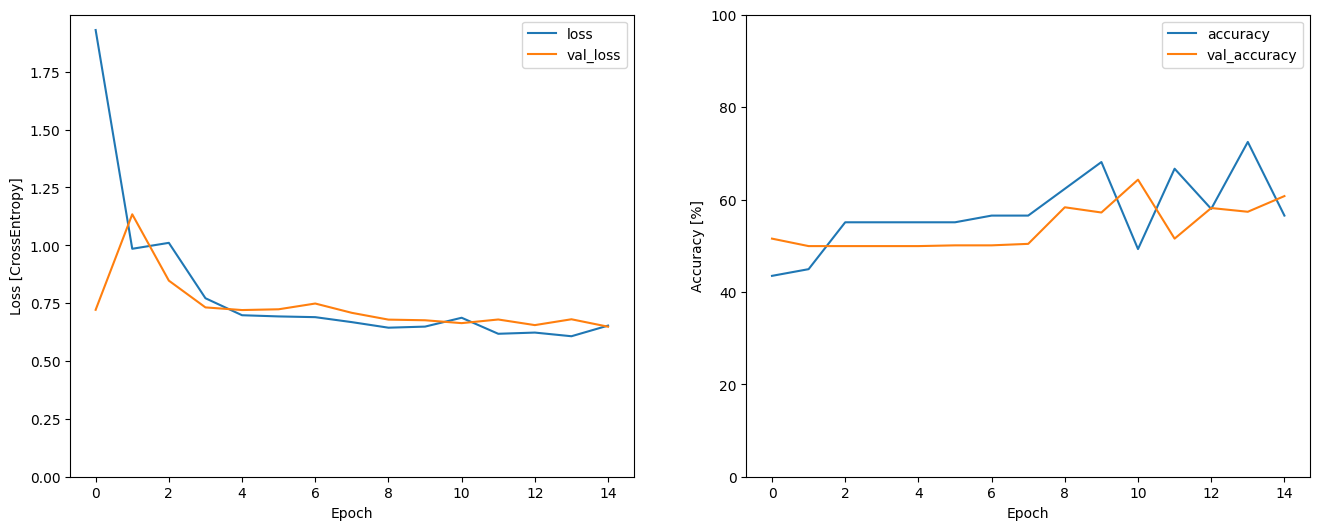

In [38]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=50,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [39]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [40]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

20/20 [==============================] - 0s 9ms/step - loss: 2.5971 - accuracy: 0.4960
MFCC Seq: [2.5970568656921387, 0.4959612190723419]
20/20 [==============================] - 0s 5ms/step - loss: 1.0922 - accuracy: 0.4378
MFCC Conv: [1.092164158821106, 0.43780291080474854]
20/20 [==============================] - 0s 9ms/step - loss: 3.4942 - accuracy: 0.5073
Spec Seq: [3.494232416152954, 0.5072697997093201]
20/20 [==============================] - 0s 9ms/step - loss: 6.8709 - accuracy: 0.5040
Spec Conv: [6.8709397315979, 0.5040387511253357]


### [Reinf] [MFCCs] Sequential model

Epoch 1/50
3/3 [==============================] - 1s 138ms/step - loss: 2.4548 - accuracy: 0.5652 - val_loss: 3.0278 - val_accuracy: 0.6123
Epoch 2/50
3/3 [==============================] - 0s 85ms/step - loss: 1.2681 - accuracy: 0.6812 - val_loss: 1.0973 - val_accuracy: 0.6721
Epoch 3/50
3/3 [==============================] - 0s 88ms/step - loss: 1.0168 - accuracy: 0.8406 - val_loss: 1.0109 - val_accuracy: 0.7108
Epoch 4/50
3/3 [==============================] - 0s 87ms/step - loss: 0.4881 - accuracy: 0.8986 - val_loss: 1.2160 - val_accuracy: 0.7722
Epoch 5/50
3/3 [==============================] - 0s 82ms/step - loss: 0.2958 - accuracy: 0.8696 - val_loss: 1.7472 - val_accuracy: 0.7561
Epoch 6/50
3/3 [==============================] - 0s 82ms/step - loss: 0.3695 - accuracy: 0.8406 - val_loss: 1.5444 - val_accuracy: 0.7609
Epoch 7/50
3/3 [==============================] - 0s 85ms/step - loss: 0.1394 - accuracy: 0.9420 - val_loss: 0.9082 - val_accuracy: 0.7690
Epoch 8/50
3/3 [==========

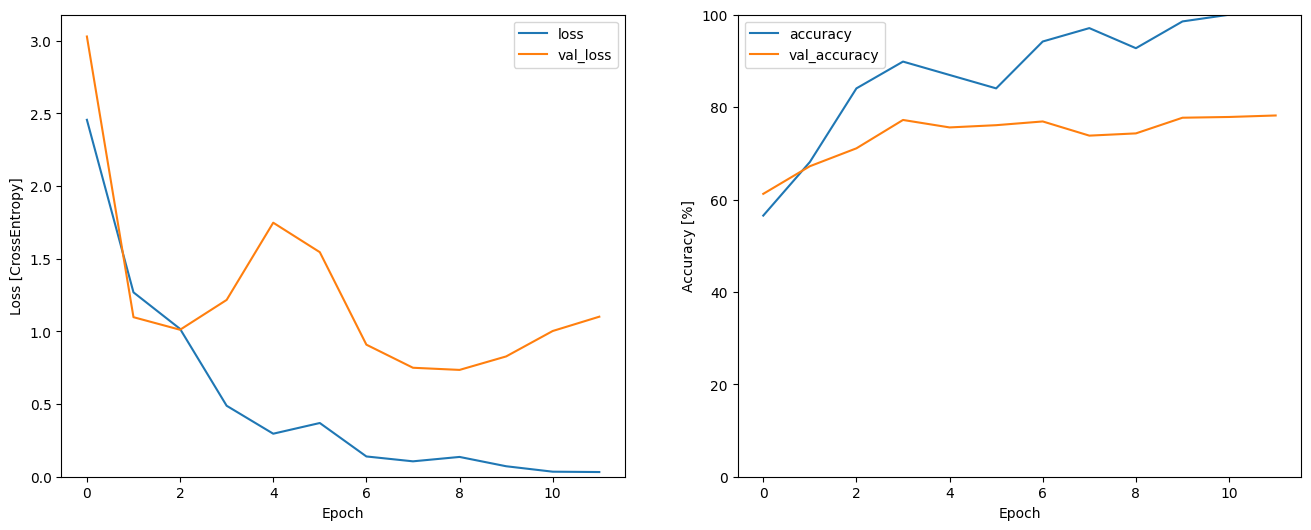

In [41]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=50,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/50
3/3 [==============================] - 0s 73ms/step - loss: 1.0985 - accuracy: 0.4348 - val_loss: 0.9790 - val_accuracy: 0.5250
Epoch 2/50
3/3 [==============================] - 0s 35ms/step - loss: 1.0238 - accuracy: 0.4928 - val_loss: 0.9281 - val_accuracy: 0.4847
Epoch 3/50
3/3 [==============================] - 0s 33ms/step - loss: 0.7216 - accuracy: 0.5217 - val_loss: 0.8671 - val_accuracy: 0.6397
Epoch 4/50
3/3 [==============================] - 0s 36ms/step - loss: 0.6557 - accuracy: 0.7101 - val_loss: 0.8301 - val_accuracy: 0.5412
Epoch 5/50
3/3 [==============================] - 0s 35ms/step - loss: 0.6742 - accuracy: 0.5797 - val_loss: 0.7875 - val_accuracy: 0.5719
Epoch 6/50
3/3 [==============================] - 0s 32ms/step - loss: 0.5728 - accuracy: 0.6232 - val_loss: 0.7664 - val_accuracy: 0.6559
Epoch 7/50
3/3 [==============================] - 0s 33ms/step - loss: 0.5570 - accuracy: 0.7536 - val_loss: 0.7780 - val_accuracy: 0.5832
Epoch 8/50
3/3 [===========

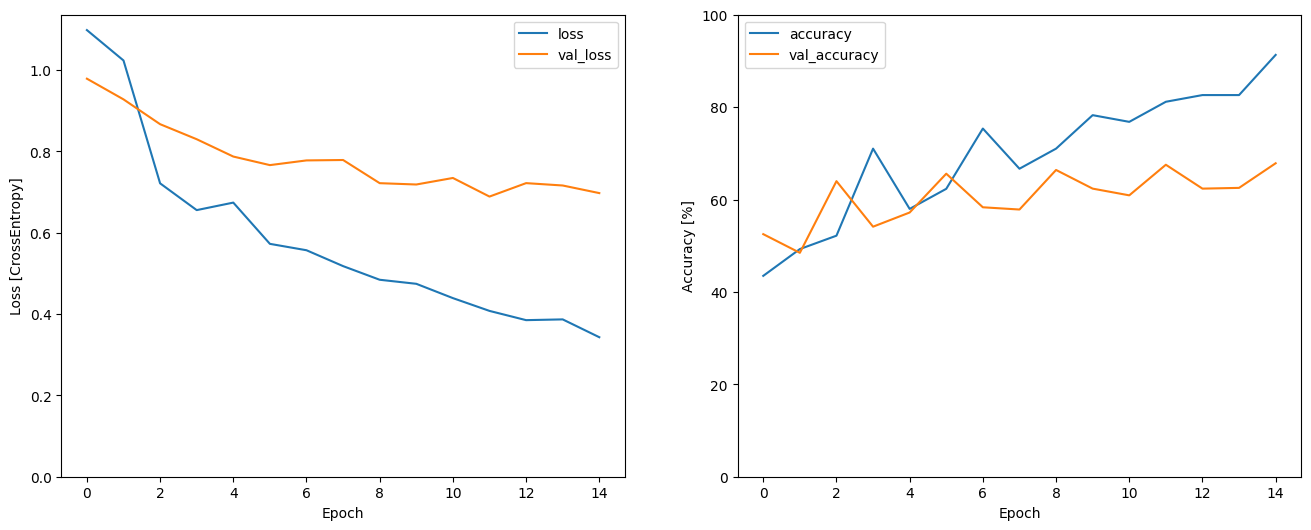

In [42]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=50,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/50
3/3 [==============================] - 1s 137ms/step - loss: 3.3545 - accuracy: 0.4638 - val_loss: 1.7281 - val_accuracy: 0.6204
Epoch 2/50
3/3 [==============================] - 0s 85ms/step - loss: 1.7017 - accuracy: 0.6377 - val_loss: 1.4087 - val_accuracy: 0.6300
Epoch 3/50
3/3 [==============================] - 0s 90ms/step - loss: 1.2529 - accuracy: 0.6522 - val_loss: 1.2799 - val_accuracy: 0.6721
Epoch 4/50
3/3 [==============================] - 0s 84ms/step - loss: 0.5196 - accuracy: 0.8261 - val_loss: 1.3379 - val_accuracy: 0.6753
Epoch 5/50
3/3 [==============================] - 0s 83ms/step - loss: 0.3122 - accuracy: 0.8551 - val_loss: 1.0994 - val_accuracy: 0.6785
Epoch 6/50
3/3 [==============================] - 0s 97ms/step - loss: 0.2563 - accuracy: 0.8696 - val_loss: 1.7809 - val_accuracy: 0.6284
Epoch 7/50
3/3 [==============================] - 0s 89ms/step - loss: 0.2214 - accuracy: 0.9565 - val_loss: 1.3367 - val_accuracy: 0.6898
Epoch 8/50
3/3 [==========

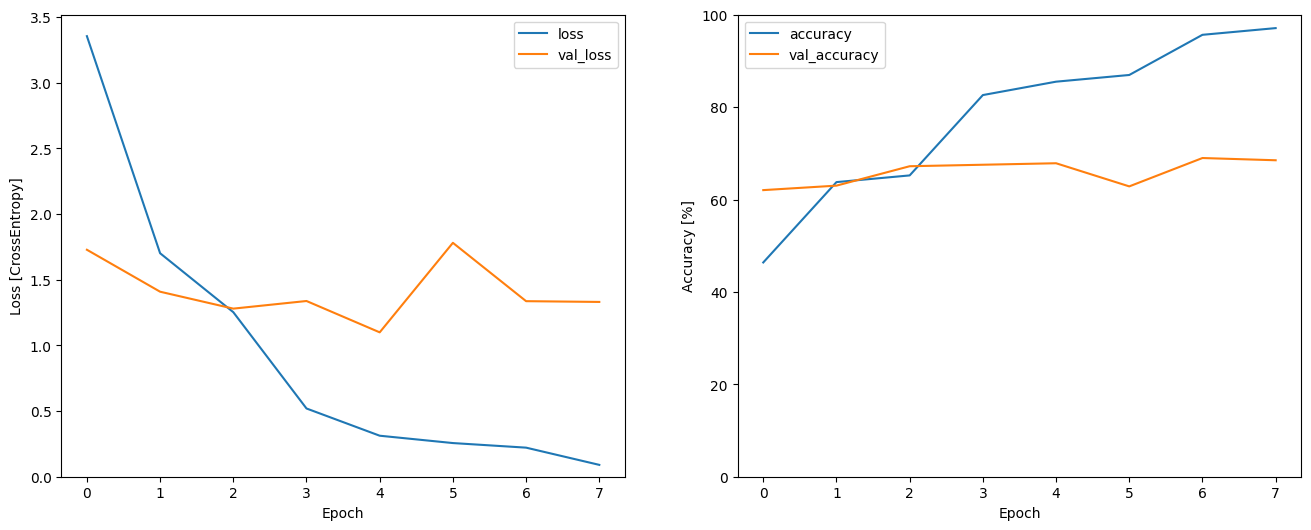

In [43]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=50,
    callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/50
3/3 [==============================] - 0s 118ms/step - loss: 4.4279 - accuracy: 0.5942 - val_loss: 5.3860 - val_accuracy: 0.5089
Epoch 2/50
3/3 [==============================] - 0s 85ms/step - loss: 3.6432 - accuracy: 0.5072 - val_loss: 2.4048 - val_accuracy: 0.5089
Epoch 3/50
3/3 [==============================] - 0s 80ms/step - loss: 2.5107 - accuracy: 0.5942 - val_loss: 2.3800 - val_accuracy: 0.5057
Epoch 4/50
3/3 [==============================] - 0s 79ms/step - loss: 1.3813 - accuracy: 0.6377 - val_loss: 2.6484 - val_accuracy: 0.5250
Epoch 5/50
3/3 [==============================] - 0s 80ms/step - loss: 2.6288 - accuracy: 0.4783 - val_loss: 1.5547 - val_accuracy: 0.5929
Epoch 6/50
3/3 [==============================] - 0s 79ms/step - loss: 1.4333 - accuracy: 0.5507 - val_loss: 1.7242 - val_accuracy: 0.5218
Epoch 7/50
3/3 [==============================] - 0s 84ms/step - loss: 1.2918 - accuracy: 0.5797 - val_loss: 1.0626 - val_accuracy: 0.6010
Epoch 8/50
3/3 [==========

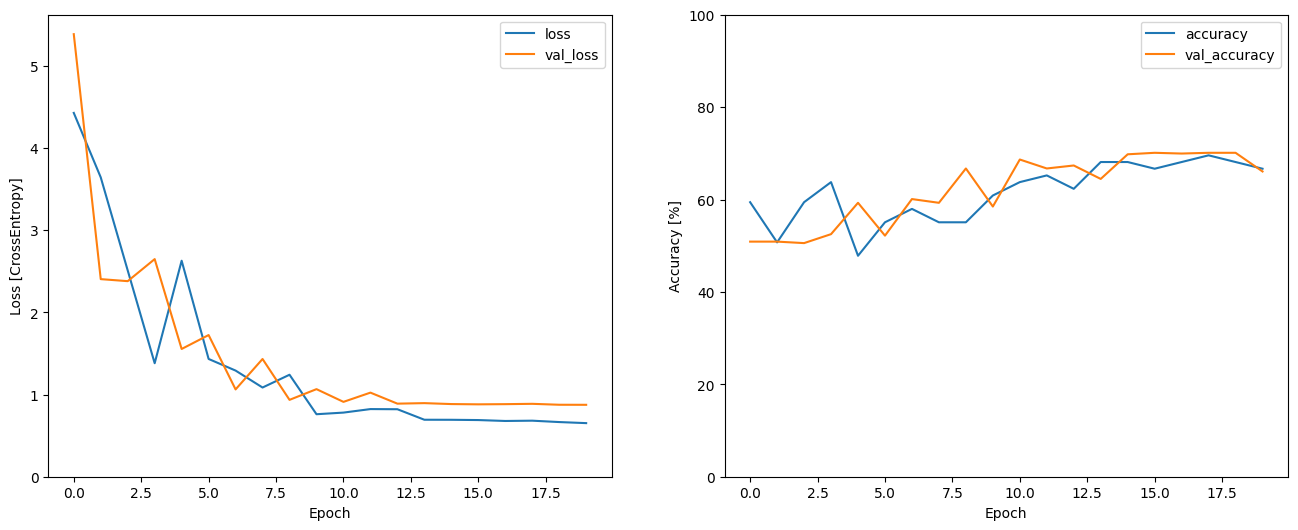

In [44]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=50,
    callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [ ]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')